In [38]:
import matplotlib.pyplot as plt

import torch

from torchvision.datasets import CIFAR10
from torchvision import transforms

from torch.utils.data import DataLoader

from glow import GLOW

import normflows as nf

import torchvision as tv
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    nf.utils.Scale(255. / 256.),
    nf.utils.Jitter(1 / 256.)
])

train_data = CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, drop_last=True)

flow = GLOW(3, 32, (3, 32, 32), 10, 256)
flow.model.load('models/glow_cifar_3_32_256_104100.pt')
#flow.fit(train_loader, 40000)

Files already downloaded and verified


/home/mando/glime/.venv/lib/python3.10/site-packages/normflows/core.py:632: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


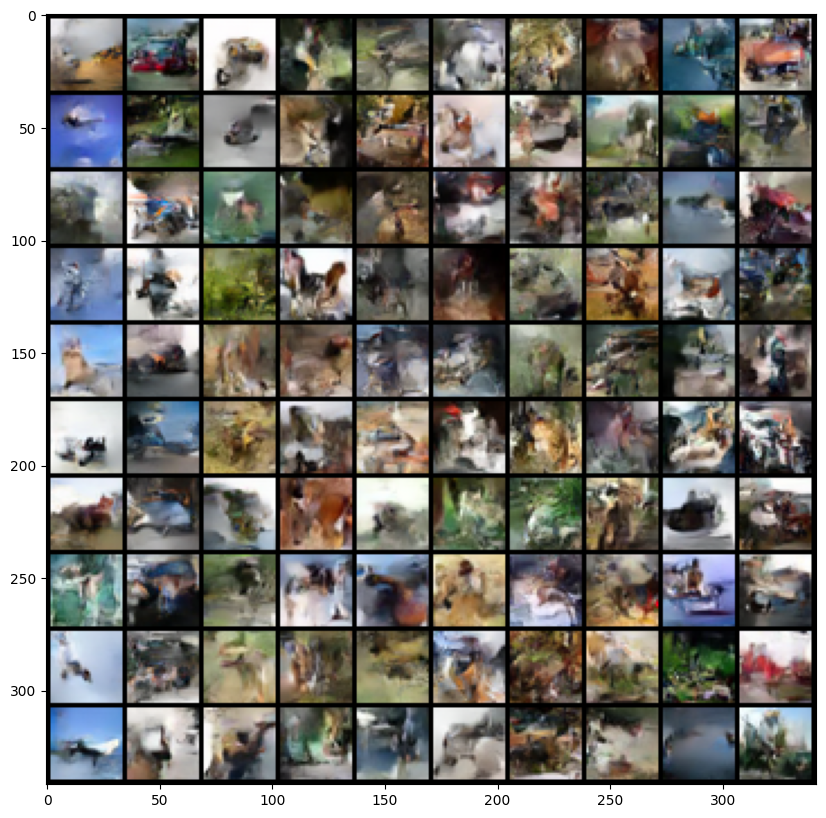

In [48]:
num_sample = 10

with torch.no_grad():
    y = torch.arange(10).repeat(num_sample).to('cuda:1')
    x, _ = flow.model.sample(y=y)
    x_ = torch.clamp(x, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(tv.utils.make_grid(x_, nrow=10).cpu().numpy(), (1, 2, 0)))
    plt.show()

In [81]:
from PIL import Image

input_image = Image.open("data/puppykitty.jpg")

preprocess = transforms.Compose([
    transforms.Resize(48),
    transforms.CenterCrop(48),
    transforms.ToTensor(),
])
input_tensor = preprocess(input_image)
sample = input_tensor.unsqueeze(0)
latent = flow.to_latent(sample)
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet32", pretrained=True).to('cuda:1')
model.eval()

def print_top5(input_batch):

    with torch.no_grad():
        output = model(input_batch)

    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Read the categories
    with open("data/cifar10_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]

    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(top5_catid[i].item(), categories[top5_catid[i]], top5_prob[i].item())


def counterfactual(flow, sample, target, confidence, lr=5e-3, max_iter=1000):
    # based on 'Diffeomorphic Explanations with Normalizing Flows', Dombrowski et. al
    latent = flow.to_latent(sample)

    latent[0] = latent[0].detach()
    latent[0].requires_grad = True

    model.eval()
    model.requires_grad_(False)

    flow.model.eval()
    flow.model.requires_grad_(False)
    optimizer = torch.optim.Adam([latent[0]], lr=lr)
    for i in range(max_iter):
        optimizer.zero_grad()
        x = flow.to_image(latent)[0]
        output = model(x)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        loss = -probs[target]
        print(f'Iteration {i}, loss: {loss.item()}', end='\r')
        loss.backward(retain_graph=True)
        optimizer.step()
        if probs[target] > confidence:
            break
    return flow.to_image(latent)

Using cache found in /home/mando/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


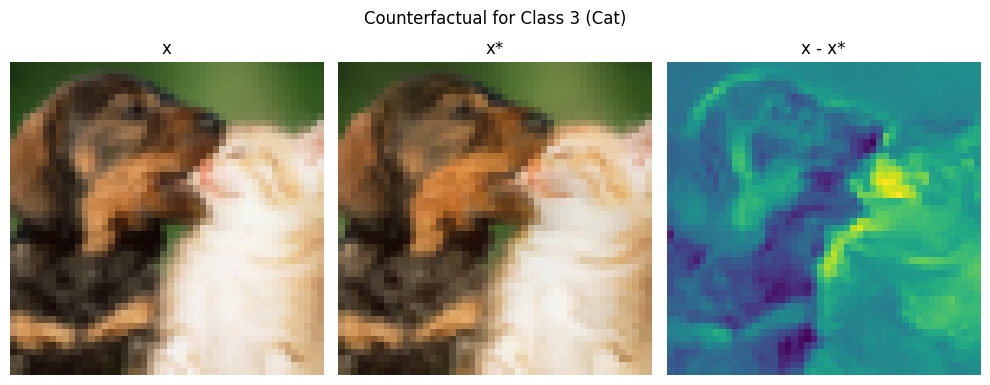

In [86]:
reconstructed = counterfactual(flow, sample, 3, 0.99)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))


ax1.imshow(sample.squeeze().detach().numpy().transpose(1, 2, 0))
ax1.axis('off')
ax1.set_title('x')

ax2.imshow(reconstructed[0].squeeze().detach().cpu().numpy().transpose(1, 2, 0))
ax2.axis('off')
ax2.set_title('x*')
# for both immages, sum the absolute values of each color channel
sample_sum = torch.sum(torch.abs(sample), dim=1)
reconstructed_sum = torch.sum(torch.abs(reconstructed[0].detach().cpu()), dim=1)
ax3.imshow((sample_sum - reconstructed_sum).detach().cpu().numpy().transpose(1, 2, 0))
ax3.axis('off')
ax3.set_title('x - x*')

fig.suptitle('Counterfactual for Class 3 (Cat)')
fig.tight_layout()
plt.show()

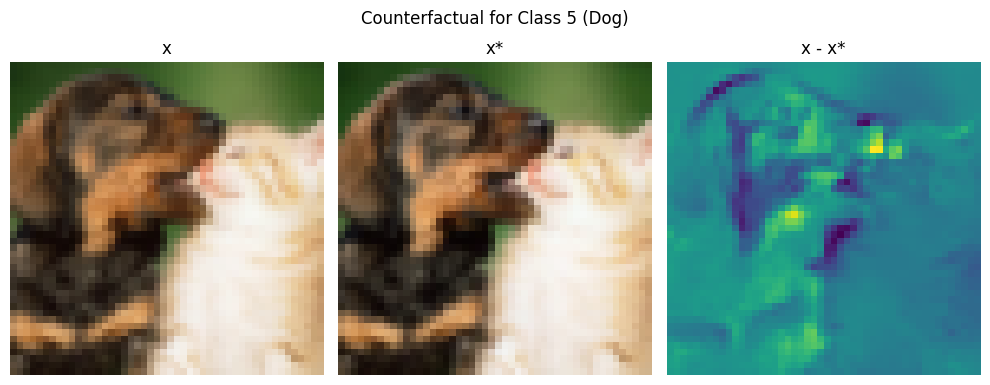

In [83]:
reconstructed = counterfactual(flow, sample, 5, 0.99)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))


ax1.imshow(sample.squeeze().detach().numpy().transpose(1, 2, 0))
ax1.axis('off')
ax1.set_title('x')

ax2.imshow(reconstructed[0].squeeze().detach().cpu().numpy().transpose(1, 2, 0))
ax2.axis('off')
ax2.set_title('x*')
# for both immages, sum the absolute values of each color channel
sample_sum = torch.sum(torch.abs(sample), dim=1)
reconstructed_sum = torch.sum(torch.abs(reconstructed[0].detach().cpu()), dim=1)
ax3.imshow((sample_sum - reconstructed_sum).detach().cpu().numpy().transpose(1, 2, 0))
ax3.axis('off')
ax3.set_title('x - x*')

fig.suptitle('Counterfactual for Class 5 (Dog)')
fig.tight_layout()
plt.show()